### Predict future loan demand or interest rates using time series analysis.

In [9]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')

# Convert to a DataFrame and reset the index
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data from 2014 onwards
data = data[data['Date'] >= '2008-01-01']

# Display first few rows of the filtered data
print(data.head())



            Date  Interest Rate
12000 2008-01-01            NaN
12001 2008-01-02           3.91
12002 2008-01-03           3.91
12003 2008-01-04           3.88
12004 2008-01-07           3.86


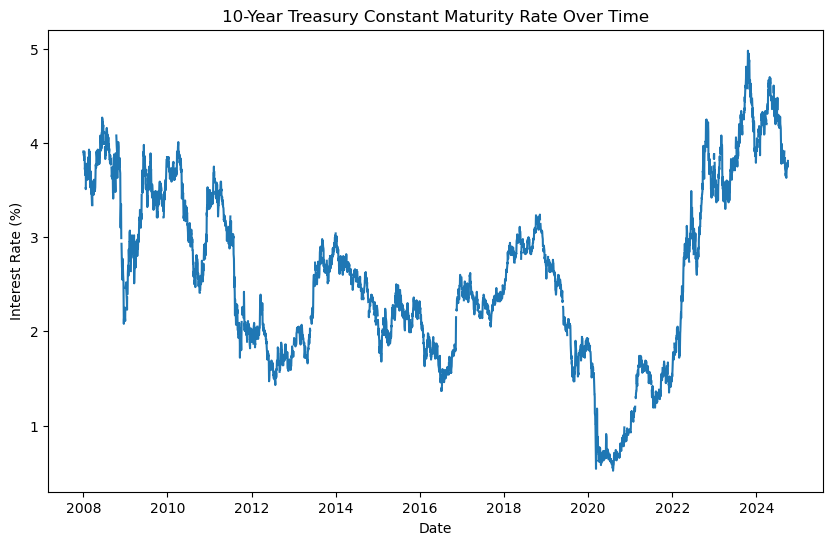

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'])
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.show()

In [36]:
# Reset the index to bring back the 'Date' column if it was the index
data.reset_index(inplace=True)

print(data.columns)

Index(['Date', 'Interest Rate'], dtype='object')


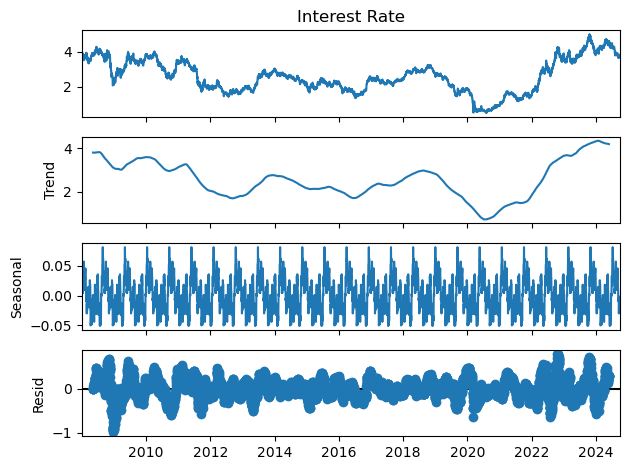

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the 'Date' column as the index and ensure it's sorted
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # Set frequency as daily for the decomposition
data = data.fillna(method='ffill')  # Fill any missing values

# Perform seasonal decomposition using a yearly pattern (252 trading days)
decomposition = seasonal_decompose(data['Interest Rate'], model='additive', period=252)

# Plot the decomposed components: trend, seasonal, and residual
decomposition.plot()
plt.tight_layout()
plt.show()


In [11]:
# Check for stationarity with ADF Test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.9662693826804274
p-value: 0.30155574977435273


<Figure size 1000x600 with 0 Axes>

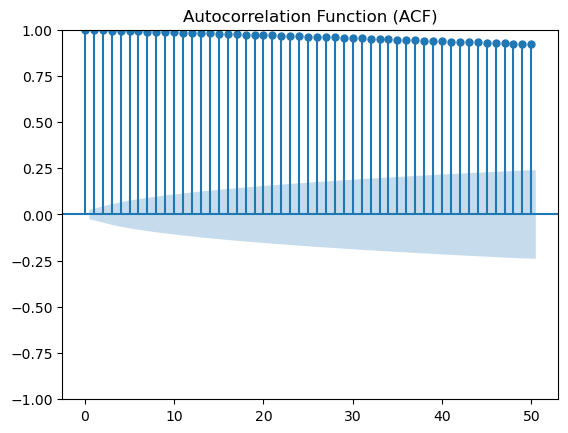

<Figure size 1000x600 with 0 Axes>

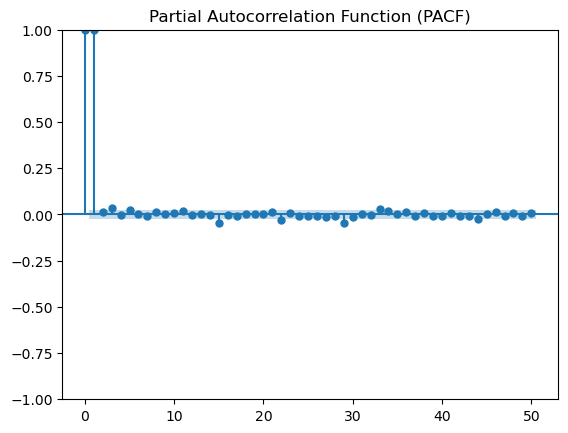

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF for the original data
plt.figure(figsize=(10, 6))
plot_acf(data['Interest Rate'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot the PACF for the original data
plt.figure(figsize=(10, 6))
plot_pacf(data['Interest Rate'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

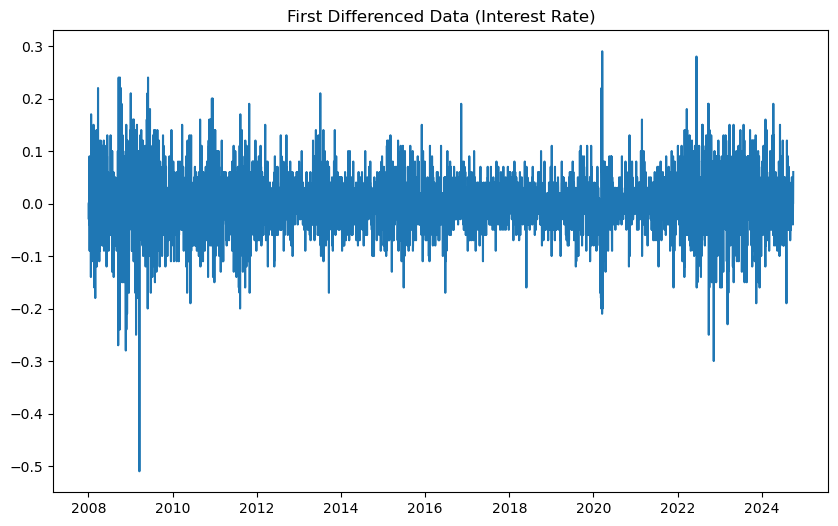

In [42]:
# Differencing to remove trends
data_diff = data['Interest Rate'].diff().dropna()

# Plot the differenced data to visualize
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title('First Differenced Data (Interest Rate)')
plt.show()

<Figure size 1000x600 with 0 Axes>

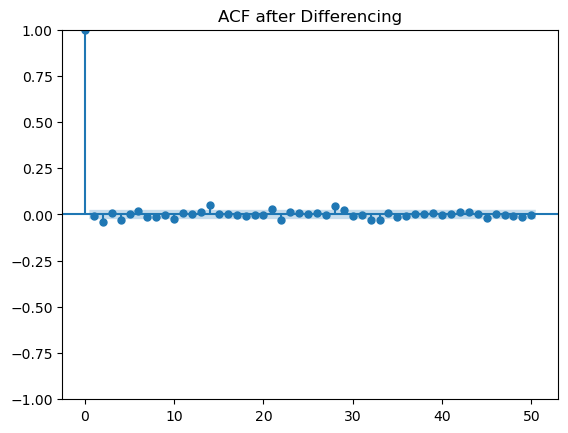

<Figure size 1000x600 with 0 Axes>

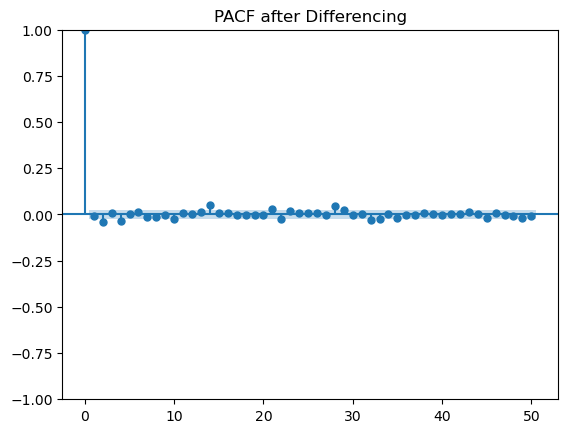

In [40]:
# Rechecking ACF and PACF after differencing the data
plt.figure(figsize=(10, 6))
plot_acf(data_diff, lags=50)
plt.title('ACF after Differencing')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data_diff, lags=50)
plt.title('PACF after Differencing')
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the differenced data
adf_test_diff = adfuller(data_diff)
print(f'ADF Statistic (after differencing): {adf_test_diff[0]}')
print(f'p-value (after differencing): {adf_test_diff[1]}')

# Interpretation: A p-value < 0.05 suggests the data is now stationary

ADF Statistic (after differencing): -12.89406690291023
p-value (after differencing): 4.386439481216402e-24


            Date  Interest Rate
12001 2008-01-02           3.91
12002 2008-01-03           3.91
12003 2008-01-04           3.88
12004 2008-01-07           3.86
12005 2008-01-08           3.86
Training data shape: (3607, 1)
Testing data shape: (584, 1)


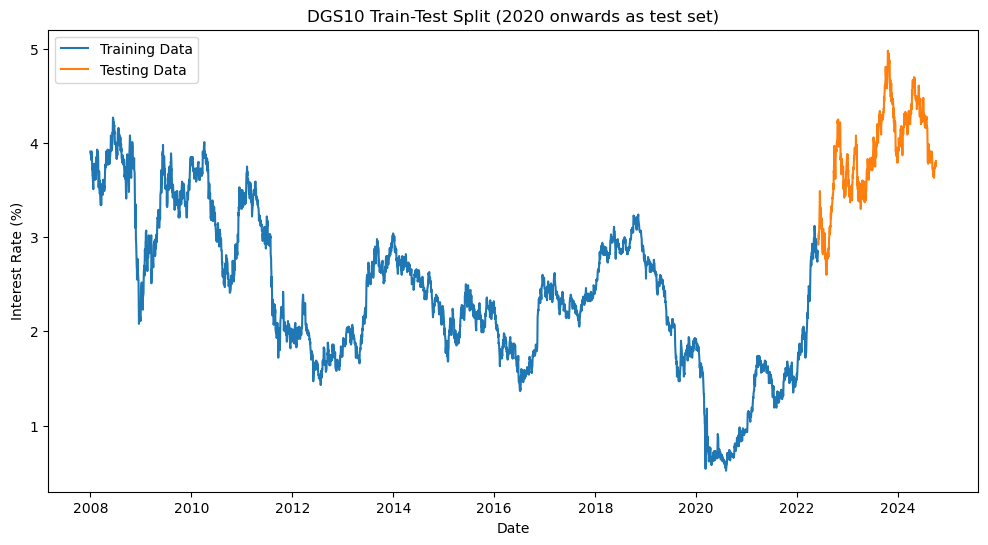

In [15]:
# Remove rows with NaN values
data = data.dropna()

# Display first few rows of the cleaned data
print(data.head())

# Convert 'Date' to datetime if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date to ensure chronological order
data = data.sort_values('Date')

# Split the data
train_data = data[data['Date'] < '2022-06-01']
test_data = data[data['Date'] >= '2022-06-01']

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Testing Data')
plt.title('DGS10 Train-Test Split (2020 onwards as test set)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

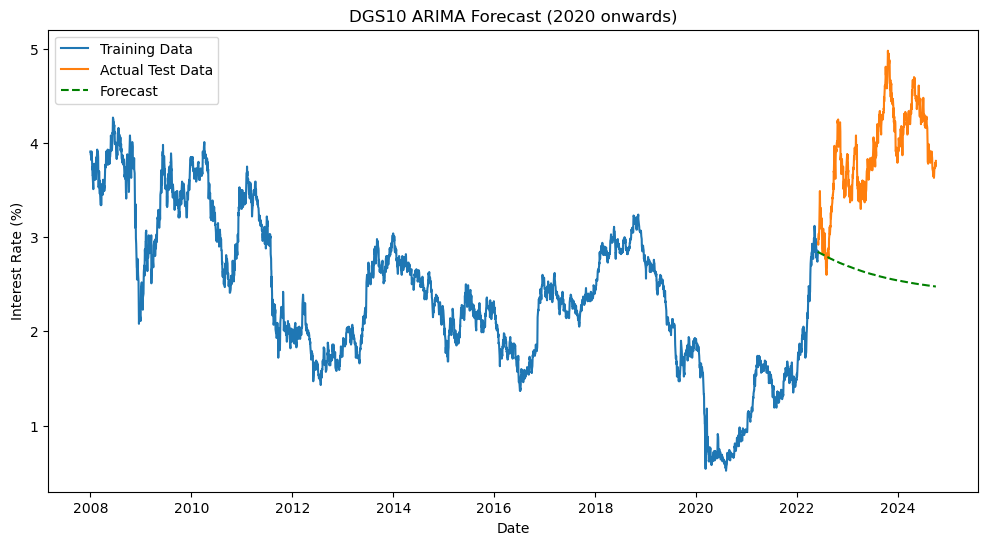

In [32]:
# Fit ARIMA model
model = ARIMA(train_data['Interest Rate'], order=(2,0,2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')
plt.title('DGS10 ARIMA Forecast (2020 onwards)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

In [79]:
print("Shape of test_data['Interest Rate']:", test_data['Interest Rate'].shape)
print("Shape of forecast:", forecast.shape)

Shape of test_data['Interest Rate']: (1131,)
Shape of forecast: (1131,)


In [80]:
print("NaN values in test_data:", test_data['Interest Rate'].isna().sum())
print("NaN values in forecast:", forecast.isna().sum())
print("Infinite values in test_data:", np.isinf(test_data['Interest Rate']).sum())
print("Infinite values in forecast:", np.isinf(forecast).sum())

NaN values in test_data: 45
NaN values in forecast: 0
Infinite values in test_data: 0
Infinite values in forecast: 0


In [81]:
mask = ~(np.isnan(test_data['Interest Rate']) | np.isinf(test_data['Interest Rate']) | 
         np.isnan(forecast) | np.isinf(forecast))

# Calculate RMSE only on valid values
rmse = np.sqrt(mean_squared_error(test_data['Interest Rate'][mask], forecast[mask]))
print(f'RMSE: {rmse}')

RMSE: 2.9547840547762156


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the data
train_data = data[data['Date'] < '2020-06-01']
test_data = data[data['Date'] >= '2020-06-01']

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

model = SARIMAX(train_data['Interest Rate'], 
                order=(0, 2, 2),           # Non-seasonal part (p, d, q)
                seasonal_order=(1, 1, 1, 252))  # Seasonal part (P, D, Q, S)

# Fit the model
model_fit = model.fit()

# Forecast the test set length
forecast = model_fit.forecast(steps=len(test_data))

# Plot the results (including training, test, and forecast data)
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='SARIMA Forecast', color='blue', linestyle='--')
plt.title('DGS10 SARIMA Forecast (All Data)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()